# Demonstrate issues with deepCoadd WCS

 * Melissa Graham
 * Fri Apr 29
 * data-int.lsst.cloud
 * DP0.2 test set from butler
 * Weekly 2022_12

**Problem:** When using matplotlib as the backend to afw.display, and overlaying an RA,Dec grid using astropy.wcs.WCS as the projection passed to matplotlib.pyplot.subplot, if you do not use `extent` with imshow then the RA,Dec grid will be correct only if the origin is (0,0). Thus, overlaying an RA,Dec grid like this works for a calexp but not for a deepCoadd.

Overlaying an RA,Dec grid using astropy.wcs.WCS was recommended in, e.g., <br>
https://community.lsst.org/t/visualizing-images-in-sky-coordinates-using-wcs-in-a-notebook/4210

# 1.0 Set up

## 1.1 Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas
pandas.set_option('display.max_rows', 1000)

import lsst.daf.butler as dafButler

import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

## 1.2 Choose a deepCoadd image of a cluster that we are familiar with.

In [2]:
repo = 's3://butler-us-central1-panda-dev/dc2/butler-external.yaml'
collection = '2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'
butler = dafButler.Butler(repo, collections=collection)

In [3]:
my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees,
                                       -32.269167*lsst.geom.degrees)
skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
dataId = {'band': 'i', 'tract': 4431, 'patch': 17}

In [4]:
deepCoadd        = butler.get('deepCoadd_calexp', dataId=dataId)
deepCoadd_bbox   = butler.get('deepCoadd_calexp.bbox', dataId=dataId)
deepCoadd_wcs    = butler.get('deepCoadd_calexp.wcs', dataId=dataId)
deepCoadd_fitsMd = deepCoadd_wcs.getFitsMetadata()
deepCoadd_WCSfMd = WCS(deepCoadd_wcs.getFitsMetadata())

## 1.3 Choose a calexp that we know should overlap with this deepCoadd

In [5]:
coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)
coadd_inputs_ccds_table = coadd_inputs.ccds.asAstropy()
use_detector = coadd_inputs_ccds_table['ccd'][0]
use_visit = coadd_inputs_ccds_table['visit'][0]
print(use_detector, use_visit)

0 227922


In [6]:
calexp        = butler.get('calexp', detector=use_detector, visit=use_visit)
calexp_bbox   = butler.get('calexp.bbox', detector=use_detector, visit=use_visit)
calexp_wcs    = butler.get('calexp.wcs', detector=use_detector, visit=use_visit)
calexp_fitsMd = calexp_wcs.getFitsMetadata()
calexp_WCSfMd = WCS(calexp_wcs.getFitsMetadata())

## 1.4 Get the corners and prove this calexp overlaps this deepCoadd

Index corners starting lower left and going clockwise: 0 lower left, 1 upper left, 2 upper right, 3 lower right

In [7]:
print('# # # # # deepCoadd bbox in pixels # # # # #')
print(deepCoadd_bbox.beginX, deepCoadd_bbox.endX, deepCoadd_bbox.beginY, deepCoadd_bbox.endY)
print(' ')
print('# # # # # calexp bbox in pixels # # # # #')
print(calexp_bbox.beginX, calexp_bbox.endX, calexp_bbox.beginY, calexp_bbox.endY)

# # # # # deepCoadd bbox in pixels # # # # #
11900 16100 7900 12100
 
# # # # # calexp bbox in pixels # # # # #
0 4072 0 4000


In [8]:
### deepCoadd's corners
dc_crnrs = [ deepCoadd_wcs.pixelToSky(deepCoadd_bbox.beginX, deepCoadd_bbox.beginY), 
             deepCoadd_wcs.pixelToSky(deepCoadd_bbox.beginX, deepCoadd_bbox.endY), 
             deepCoadd_wcs.pixelToSky(deepCoadd_bbox.endX, deepCoadd_bbox.endY), 
             deepCoadd_wcs.pixelToSky(deepCoadd_bbox.endX, deepCoadd_bbox.beginY) ]

### calexp's corners
ca_crnrs = [ calexp_wcs.pixelToSky(calexp_bbox.beginX, calexp_bbox.beginY), 
             calexp_wcs.pixelToSky(calexp_bbox.beginX, calexp_bbox.endY), 
             calexp_wcs.pixelToSky(calexp_bbox.endX, calexp_bbox.endY), 
             calexp_wcs.pixelToSky(calexp_bbox.endX, calexp_bbox.beginY) ]

# # # # # deepCoadd corners: # # # # #
0  55.79016 -32.32223 03h43m09.6s -32d19m20.0s
1  55.78981 -32.08890 03h43m09.5s -32d05m20.0s
2  55.51440 -32.08890 03h42m03.4s -32d05m20.0s
3  55.51405 -32.32223 03h42m03.3s -32d19m20.0s
 
# # # # # calexp corners: # # # # #
0  55.53613 -32.32160 03h42m08.6s -32d19m17.7s
1  55.54250 -32.10015 03h42m10.2s -32d06m00.5s
2  55.27598 -32.09490 03h41m06.2s -32d05m41.6s
3  55.26904 -32.31637 03h41m04.5s -32d18m58.9s


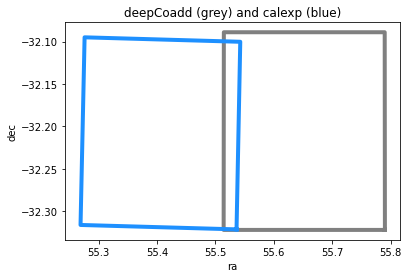

In [9]:
print('# # # # # deepCoadd corners: # # # # #')
dc_crnrs_deg = np.zeros((4,2), dtype = 'float')
for i in range(4):
    dc_crnrs_deg[i,0] = dc_crnrs[i].getRa().asDegrees()
    dc_crnrs_deg[i,1] = dc_crnrs[i].getDec().asDegrees()
    coord = SkyCoord(ra = dc_crnrs[i].getRa().asDegrees()*u.degree, 
                     dec = dc_crnrs[i].getDec().asDegrees()*u.degree)
    ra = str(coord.to_string('hmsdms')).split()[0]
    dec = str(coord.to_string('hmsdms')).split()[1]
    print('%1i %9.5f %9.5f %10ss %11ss' % (i, dc_crnrs_deg[i,0], dc_crnrs_deg[i,1], ra[0:10], dec[0:11]))
print(' ')

print('# # # # # calexp corners: # # # # #')
ca_crnrs_deg = np.zeros((4,2), dtype = 'float')
for i in range(4):
    ca_crnrs_deg[i,0] = ca_crnrs[i].getRa().asDegrees()
    ca_crnrs_deg[i,1] = ca_crnrs[i].getDec().asDegrees()
    coord = SkyCoord(ra = ca_crnrs[i].getRa().asDegrees()*u.degree, 
                     dec = ca_crnrs[i].getDec().asDegrees()*u.degree)
    ra = str(coord.to_string('hmsdms')).split()[0]
    dec = str(coord.to_string('hmsdms')).split()[1]
    print('%1i %9.5f %9.5f %10ss %11ss' % (i, ca_crnrs_deg[i,0], ca_crnrs_deg[i,1], ra[0:10], dec[0:11]))
    
fig = plt.figure(figsize=(6,4))
plt.plot( [dc_crnrs_deg[0][0], dc_crnrs_deg[1][0], dc_crnrs_deg[2][0], dc_crnrs_deg[3][0], dc_crnrs_deg[0][0]], 
          [dc_crnrs_deg[0][1], dc_crnrs_deg[1][1], dc_crnrs_deg[2][1], dc_crnrs_deg[3][1], dc_crnrs_deg[0][1]],
          ls='solid', lw=4, alpha=1, color='grey' )
plt.plot( [ca_crnrs_deg[0][0], ca_crnrs_deg[1][0], ca_crnrs_deg[2][0], ca_crnrs_deg[3][0], ca_crnrs_deg[0][0]], 
          [ca_crnrs_deg[0][1], ca_crnrs_deg[1][1], ca_crnrs_deg[2][1], ca_crnrs_deg[3][1], ca_crnrs_deg[0][1]],
          ls='solid', lw=4, alpha=1, color='dodgerblue' )
plt.xlabel( 'ra' )
plt.ylabel( 'dec' )
plt.title( 'deepCoadd (grey) and calexp (blue)' )
plt.show()  

# 3.0 Plot with imshow, overlay RA,Dec grid

## 3.1 Show how the overlayed RA,Dec grid is incorrect for the deepCoadd

See that the corners and RA/Dec grid do not match for the deepCoadd, but do match for the calexp.

See that the coordinates for the circled star do not match between deepCoadd and calexp.

deepCoadd yellow circle:  03h45m16.11855576s -32d44m33.81450098s
calexp pink circle:  03h42m07.6818663s -32d18m19.67891667s


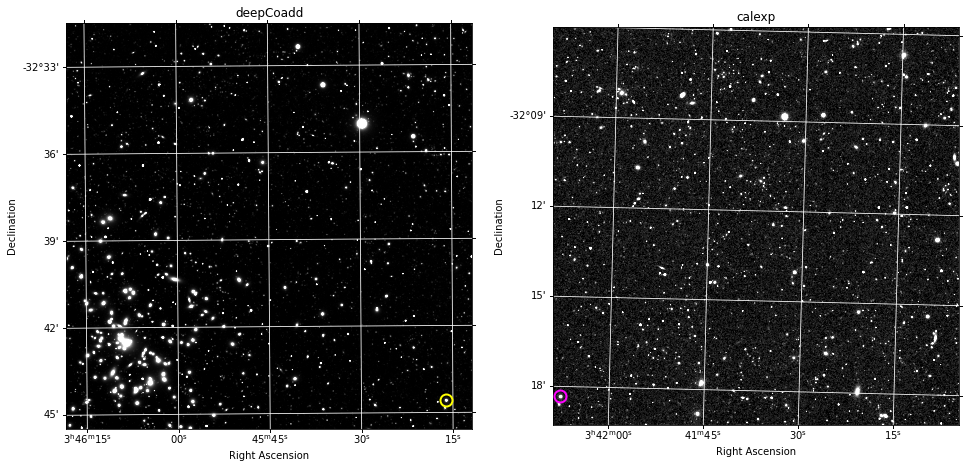

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=False, sharey=False)

### deepCoadd
plt.subplot(1, 2, 1, projection=deepCoadd_WCSfMd)
plt.imshow(deepCoadd.image.array, cmap='gray', vmin=0, vmax=2, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('deepCoadd')

### yellow circle on deepCoadd
test_pix_x = 3930
test_pix_y = 300
plt.plot( test_pix_x, test_pix_y, 'o', ms=12, color='None', mew=2, mec='yellow' )
coord_sph = deepCoadd_wcs.pixelToSky(test_pix_x, test_pix_y)
coord = SkyCoord(ra = coord_sph.getRa().asDegrees()*u.degree, 
                     dec = coord_sph.getDec().asDegrees()*u.degree)
print('deepCoadd yellow circle: ',coord.to_string('hmsdms'))

### calexp
plt.subplot(1, 2, 2,  projection=calexp_WCSfMd)
plt.imshow(calexp.image.array, cmap='gray', vmin=-10, vmax=100, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('calexp')

### magenta circle on calexp
test_pix_x = 70
test_pix_y = 290
plt.plot( test_pix_x, test_pix_y, 'o', ms=12, color='None', mew=2, mec='magenta' )
coord_sph = calexp_wcs.pixelToSky(test_pix_x, test_pix_y)
coord = SkyCoord(ra = coord_sph.getRa().asDegrees()*u.degree, 
                     dec = coord_sph.getDec().asDegrees()*u.degree)
print('calexp pink circle: ',coord.to_string('hmsdms'))

plt.show()

|deepCoadd corners:      |            |calexp corners:         |
|------------------------|------------|------------------------|
|03h43m09.6s -32d19m20.0s|            |03h43m55.2s -32d23m06.1s|
|03h43m09.5s -32d05m20.0s|            |03h43m26.2s -32d11m15.8s|
|03h42m03.4s -32d05m20.0s|            |03h42m29.2s -32d17m28.9s|
|03h42m03.3s -32d19m20.0s|            |03h42m58.1s -32d29m20.0s|

## 3.2 Show that the RA,Dec grid for the deepCoadd can be fixed with `extent`

Define `extent` using the bounding box, and pass it to imshow.

Add the beginX and beginY values to the pixel coordinates of the circle.

Find that the RA,Dec grid for the deepCoadd is now correct and matches the calexp.

deepCoadd yellow circle:  03h42m07.6378733s -32d18m20.07810438s
calexp pink circle:  03h42m07.6818663s -32d18m19.67891667s


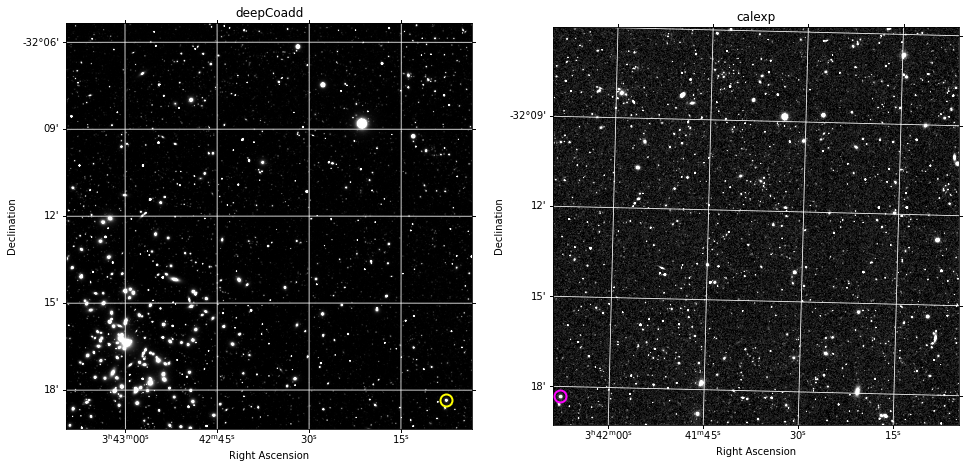

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=False, sharey=False)

plt.subplot(1, 2, 1, projection=deepCoadd_WCSfMd)
deepCoadd_extent = (deepCoadd_bbox.beginX, deepCoadd_bbox.endX, deepCoadd_bbox.beginY, deepCoadd_bbox.endY )
plt.imshow(deepCoadd.image.array, cmap='gray', vmin=0, vmax=2, extent=deepCoadd_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('deepCoadd')

test_pix_x = 3930+deepCoadd_bbox.beginX
test_pix_y = 300+deepCoadd_bbox.beginY
plt.plot( test_pix_x, test_pix_y, 'o', ms=12, color='None', mew=2, mec='yellow' )
coord_sph = deepCoadd_wcs.pixelToSky(test_pix_x, test_pix_y)
coord = SkyCoord(ra = coord_sph.getRa().asDegrees()*u.degree, 
                     dec = coord_sph.getDec().asDegrees()*u.degree)
print('deepCoadd yellow circle: ',coord.to_string('hmsdms'))

plt.subplot(1, 2, 2,  projection=calexp_WCSfMd)
calexp_extent = (calexp_bbox.beginX, calexp_bbox.endX, calexp_bbox.beginY, calexp_bbox.endY )
plt.imshow(calexp.image.array, cmap='gray', vmin=-10, vmax=100, extent=calexp_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('calexp')

test_pix_x = 70+calexp_bbox.beginX
test_pix_y = 290+calexp_bbox.beginY
plt.plot( test_pix_x, test_pix_y, 'o', ms=12, color='None', mew=2, mec='magenta' )
coord_sph = calexp_wcs.pixelToSky(test_pix_x, test_pix_y)
coord = SkyCoord(ra = coord_sph.getRa().asDegrees()*u.degree, 
                     dec = coord_sph.getDec().asDegrees()*u.degree)
print('calexp pink circle: ',coord.to_string('hmsdms'))

plt.show()

|deepCoadd corners:      |            |calexp corners:         |
|------------------------|------------|------------------------|
|03h43m09.6s -32d19m20.0s|            |03h43m55.2s -32d23m06.1s|
|03h43m09.5s -32d05m20.0s|            |03h43m26.2s -32d11m15.8s|
|03h42m03.4s -32d05m20.0s|            |03h42m29.2s -32d17m28.9s|
|03h42m03.3s -32d19m20.0s|            |03h42m58.1s -32d29m20.0s|

# 4.0 Explore potential root cause

## 4.1 Compare WCS information that we have for the deepCoadd and the calexp

There seem to be only two differences:
1. the calexps use the Simple Imaging Polynomial (SIP) convention, and the deepCoadds do not
2. for the deepCoadd, "CRPIX : 14000.0  14000.0" is outside the bounding box

In [12]:
# print('# # # # # deepCoadd_bbox # # # # #')
# print(deepCoadd_bbox)
# print(' ')
# print('# # # # # calexp_bbox # # # # #')
# print(calexp_bbox)

In [13]:
# print('# # # # # deepCoadd_wcs # # # # #')
# print(deepCoadd_wcs)
# print(' ')
# print('# # # # # calexp_wcs # # # # #')
# print(calexp_wcs)

In [14]:
# print('# # # # # deepCoadd_fitsMd # # # # #')
# print(deepCoadd_fitsMd)
# print(' ')
# print('# # # # # calexp_fitsMd # # # # #')
# print(calexp_fitsMd)

In [15]:
# print('# # # # # deepCoadd_WCSfMd # # # # #')
# print(deepCoadd_WCSfMd)
# print(' ')
# print('# # # # # calexp_WCSfMd # # # # #')
# print(calexp_WCSfMd)

## 4.2 Show that the pixel to sky conversions are the same for the Stack and Astropy

Use pixel coordinates of the star that is at RA = 55.529, Dec = -32.305.

It doesn't matter which pixel-to-sky conversion method you use, the results of the Stack's and Astropy's match.

**BUT** if you don't include the pixel boundaries for the deepCoadd the coordinates will be incorrect.

First, get the wrong star coordinates from both the Stack and astropy.wcs.WCS by not passing bounding box information.

In [16]:
test_pix_x = 3930
test_pix_y = 300
print('# # # # # The Stack # # # # #')
print(deepCoadd_wcs.pixelToSky(test_pix_x, test_pix_y))
print(' ')
print('# # # # # astropy.wcs.WCS # # # # #')
print(deepCoadd_WCSfMd.pixel_to_world(test_pix_x, test_pix_y))

# # # # # The Stack # # # # #
(56.3171606490, -32.7427262503)
 
# # # # # astropy.wcs.WCS # # # # #
<SkyCoord (ICRS): (ra, dec) in deg
    (56.31716065, -32.74272625)>


Now, get correct star coordinates from both the Stack and astropy.wcs.WCS by passing bounding box information.

In [17]:
test_pix_x = 3930+deepCoadd_bbox.beginX
test_pix_y = 300+deepCoadd_bbox.beginY
print('# # # # # The Stack # # # # #')
print(deepCoadd_wcs.pixelToSky(test_pix_x, test_pix_y))
print(' ')
print('# # # # # astropy.wcs.WCS # # # # #')
print(deepCoadd_WCSfMd.pixel_to_world(test_pix_x, test_pix_y))

# # # # # The Stack # # # # #
(55.5318244721, -32.3055772512)
 
# # # # # astropy.wcs.WCS # # # # #
<SkyCoord (ICRS): (ra, dec) in deg
    (55.53182447, -32.30557725)>


# 5.0 Further Investigations

## 5.1 firefly

Find that the deepCoadd RA,Dec are correct when we use firefly.

In [18]:
# afwDisplay.setDefaultBackend('firefly')
# afw_display = afwDisplay.Display(frame=1)

In [19]:
# afw_display.mtv(calexp)

In [20]:
# afw_display.mtv(deepCoadd)